# Trash

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import cv2
import glob
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA

path_to_dataset = "../dataset/slides/RECHERCHE-015.npy"
path_to_labels = "../dataset/annotations/RECHERCHE-015_label-015.npy"

In [ ]:
class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]

In [ ]:
class Descriptors:
    def __init__(self, dataset):
        self.dataset = dataset
        self.im_helper = ImageHelpers()
    
    def GetFeatures(self):
        descriptor_list = list()
        #for word, imlist in self.dataset:
        for image in self.dataset:
            _, des = self.im_helper.features(image)
            if des is None:
                continue
            descriptor_list.append(des)
        return descriptor_list
    
    

In [ ]:
dataset = np.load(path_to_dataset)[0:500]
datax = dataset.reshape(-1, 400*400*3)

In [ ]:
dataset = np.load(path_to_dataset)[0:50]
descriptor = Descriptors(dataset)
descriptors_list_train = descriptor.GetFeatures()
descriptors_train = np.concatenate(descriptors_list_train, axis=0)

In [ ]:
len(descriptors_train[0])

128

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, random_state = 0, n_init='auto')
kmeans_pred_train = kmeans.fit_predict(datax)

In [ ]:
kmeans_pred_train

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8,
       5, 5, 5, 5, 5, 5, 0, 5, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 8, 5, 0, 8,
       8, 0, 8, 8, 8, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 8, 0, 0, 8, 8, 8, 8,
       8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 0, 8, 5, 8, 8, 8, 8, 8, 5, 5, 8,
       5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 0, 8, 9, 9, 9, 9, 8, 5, 7, 5, 5, 0,
       5, 8, 8, 0, 0, 9, 8, 8, 8, 7, 5, 7, 5, 8, 8, 0, 0, 5, 5, 0, 0, 0,
       5, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 0, 0, 5, 0, 5, 8,
       5, 5, 5, 5, 5, 8, 8, 0, 0, 5, 5, 0, 5, 5, 0, 0, 0, 5, 5, 8, 8, 8,
       8, 8, 5, 8, 5, 5, 5, 5, 0, 8, 5, 0, 5, 5, 5, 5, 5, 5, 8, 8, 0, 0,
       8, 5, 0, 5, 5, 5, 5, 5, 0, 0, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5,
       5, 9, 5, 5, 5, 5, 5, 8, 8, 9, 9, 5, 5, 5, 5, 8, 9, 9, 9, 9, 5, 9,
       7, 5, 5, 5, 5, 8, 9, 8, 9, 9, 7, 9, 7, 5, 5, 5, 5, 8, 9, 8, 9, 9,
       7, 9, 2, 7, 5, 5, 8, 8, 8, 9, 9, 9, 9, 9, 9,

In [ ]:
def plt_image(image, label):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(label)
    # Mostra i subplot affiancati
    plt.show()

In [ ]:
maschera = np.where(kmeans_pred_train == 1)
len(maschera[0])

6

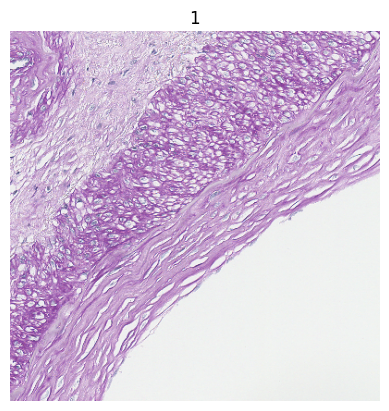

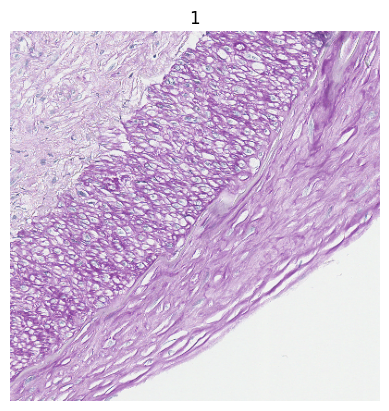

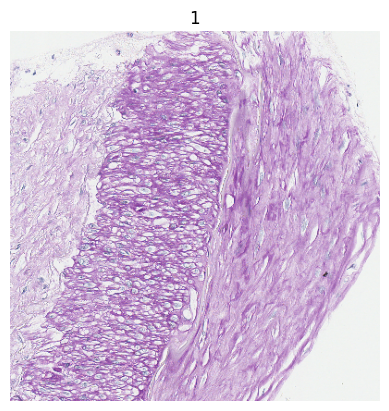

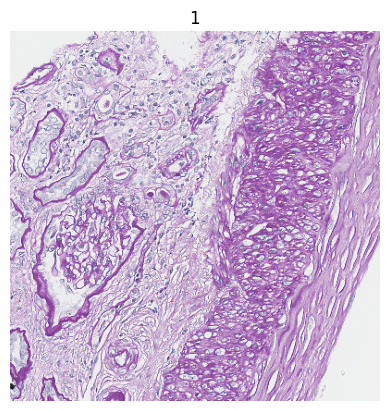

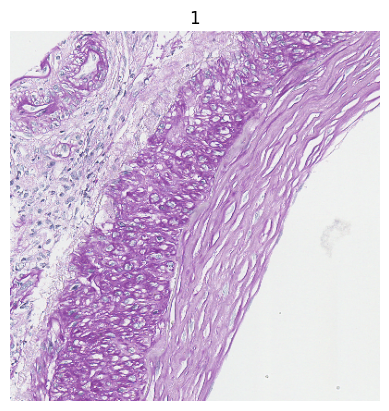

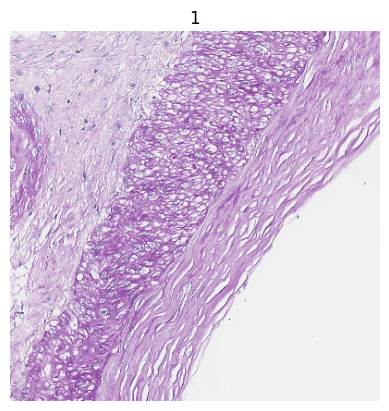

In [ ]:
for i in range(0, len(maschera[0])):
  plt_image(dataset[maschera[0][i]], kmeans_pred_train[maschera[0][i]])

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


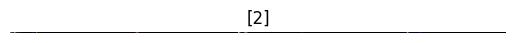

In [ ]:
for i in range(40,46):
  plt_image(dataset[i], kmeans_pred_train[i])

<Axes: >

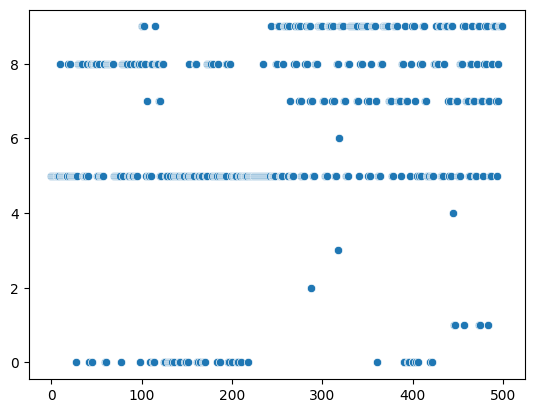

In [ ]:
import seaborn as sns

sns.scatterplot(data = kmeans_pred_train)

In [ ]:
x_data = [i for i in range(400*400*3)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2)
plt.scatter(x_data,kmeans.cluster_centers_[2] , color = 'green',alpha=0.2)

In [ ]:
kmeans.cluster_centers_[1]

array([240.91666667, 242.33333333, 240.66666667, ..., 229.91666667,
       225.70833333, 227.91666667])

# Extrapolate Glomeruli

In [2]:
def plt_image_image(imageA):
    plt.imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # Mostra i subplot affiancati
    plt.show()

In [6]:
path_to_dataset = "../dataset/slides/RECHERCHE-015.npy"
path_to_labels = "../dataset/annotations/RECHERCHE-015_label.npy"

In [7]:
dataset = np.load(path_to_dataset)[0:10]
labels = np.load(path_to_labels)[0:10]

In [8]:
glomeruli = [dataset[i] for i in range(len(dataset)) if (1 in labels[i])]
glomeruli_labels = [labels[i] for i in range(len(dataset)) if (1 in labels[i])]
notGlomeruli = [dataset[i] for i in range(len(dataset)) if not(1 in labels[i])]
notGlomeruli_labels = [labels[i] for i in range(len(dataset)) if not(1 in labels[i])]



#identify glomerulus area 
#crop_area = where(glomeruliLabels[i]==1 for i in range (len))
#cropped_image = image.crop(crop_area)


In [9]:
def estrai_parte_immagine(immagini, maschera):
    # Inizializza una lista per contenere le parti estratte dell'immagine
    parti_immagini = []

    # Itera su ogni coppia di immagine e maschera
    for img, mask in zip(immagini, maschera):
        # Applica la maschera all'immagine
        img_masked = cv2.bitwise_and(img, img, mask=mask.astype(np.uint8))

        # Aggiungi la parte estratta all'elenco
        parti_immagini.append(img_masked)

    # Converte la lista in un array numpy
    parti_immagini = np.array(parti_immagini)

    return parti_immagini

In [10]:
images = estrai_parte_immagine(glomeruli, glomeruli_labels)

In [11]:
images.shape

(6, 400, 400, 3)

In [ ]:
plt_image(images[0], labels[0])

2023-06-01 11:26:01.837 python[78802:1634387] *** Assertion failure in +[NSEvent otherEventWithType:location:modifierFlags:timestamp:windowNumber:context:subtype:data1:data2:], NSEvent.m:647
2023-06-01 11:26:01.850 python[78802:1634387] *** Assertion failure in +[NSEvent otherEventWithType:location:modifierFlags:timestamp:windowNumber:context:subtype:data1:data2:], NSEvent.m:647
2023-06-01 11:26:01.864 python[78802:1634387] *** Assertion failure in +[NSEvent otherEventWithType:location:modifierFlags:timestamp:windowNumber:context:subtype:data1:data2:], NSEvent.m:647
2023-06-01 11:26:01.877 python[78802:1634387] *** Assertion failure in +[NSEvent otherEventWithType:location:modifierFlags:timestamp:windowNumber:context:subtype:data1:data2:], NSEvent.m:647
2023-06-01 11:26:01.890 python[78802:1634387] *** Assertion failure in +[NSEvent otherEventWithType:location:modifierFlags:timestamp:windowNumber:context:subtype:data1:data2:], NSEvent.m:647
2023-06-01 11:26:01.904 python[78802:1634387]

: 